<a href="https://colab.research.google.com/github/YanghuiWu/MV-Hat/blob/main/test_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/Colab Notebooks/Hats/FinalData/
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Hats/FinalData
Data_Full/     HatsOnly.csv   lenet_hats.pt       vgg16_hats.pt
Data_Full.csv  HumanOnly/     pytorch_dataset.py  vgg16_human_only.pt
HatsOnly/      HumanOnly.csv  ReadMe.txt


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#from pytorch_dataset import HatsDataset
import torch.optim as optim


In [16]:
# for data prep
import os
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
import pickle

In [17]:
class HatsDataset(Dataset):
    def __init__(self, csv_file, root_dir,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))

        if self.transform:
            image = self.transform(image)
        return (image,y_label)

In [18]:
in_channel = 3
num_class = 15
learning_rate = 1e-5
batch_size = 16
num_epochs = 50

checkpoint = "vgg16_hats.pt"

# Prepare Dataset
dataset = HatsDataset(csv_file='Data_Full.csv', root_dir='Data_Full',
                      transform=transforms.ToTensor())  #8778

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset, testset = torch.utils.data.random_split(dataset, [8000, len(dataset) - 8000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('baseballcap', 'BikeHelmet', 'BucketHat', 'CowboyHat',
           'FeltHat', 'FireFighterHat', 'FlatCap', 'GraduationCap', 'Heaterhat', 'MilitaryHelmet',
           'MotorCycle Helmet', 'Police Hat', 'SateftyHelmet', 'TopHat', 'beanie')


In [19]:
# def imshow(img):
#     # img = img / 2 + 0.4     # unnormalize
#     npimg = img.numpy()
#     plt.figure(figsize=(16, 7))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.title('        '.join('%5s' % classes[labels[j]] for j in range(8)))
#     plt.show()
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# imshow(torchvision.utils.make_grid(images))

In [20]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.fc1 = nn.Linear(25088, 4096)
        self.fc1 = nn.Linear(int(256*256/2),4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 15)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        # x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG16()
model = model.to(device=device)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
device

device(type='cuda')

In [23]:
losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)    
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            losses.append(running_loss)
            running_loss = 0.0
            

print('Finished Training')

[1,    10] loss: 2.705
[1,    20] loss: 2.699
[1,    30] loss: 2.697
[1,    40] loss: 2.693
[1,    50] loss: 2.666
[1,    60] loss: 2.650
[1,    70] loss: 2.542
[1,    80] loss: 2.616
[1,    90] loss: 2.618
[1,   100] loss: 2.575
[1,   110] loss: 2.521
[1,   120] loss: 2.625
[1,   130] loss: 2.558
[1,   140] loss: 2.539
[1,   150] loss: 2.607
[1,   160] loss: 2.614
[1,   170] loss: 2.594
[1,   180] loss: 2.581
[1,   190] loss: 2.622
[1,   200] loss: 2.605
[1,   210] loss: 2.525
[1,   220] loss: 2.498
[1,   230] loss: 2.556
[1,   240] loss: 2.595
[1,   250] loss: 2.559
[1,   260] loss: 2.580
[1,   270] loss: 2.597
[1,   280] loss: 2.509
[1,   290] loss: 2.625
[1,   300] loss: 2.564
[1,   310] loss: 2.592
[1,   320] loss: 2.617
[1,   330] loss: 2.584
[1,   340] loss: 2.588
[1,   350] loss: 2.595
[1,   360] loss: 2.562
[1,   370] loss: 2.599
[1,   380] loss: 2.582
[1,   390] loss: 2.558
[1,   400] loss: 2.599
[1,   410] loss: 2.470
[1,   420] loss: 2.604
[1,   430] loss: 2.656
[1,   440] 

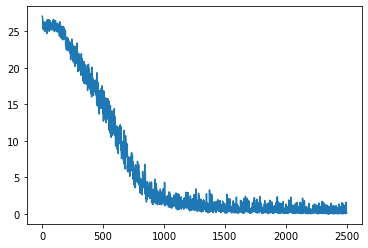

In [24]:

torch.save(model.state_dict(), checkpoint)

plt.plot(losses)

In [25]:
correct = 0
total = 0

# reinitialize the model because the evaluation does not need dropout
model = VGG16() 
model.load_state_dict(torch.load(checkpoint))
model.eval()
model.to('cuda')
# YOUR CODE HERE
# raise NotImplementedError()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # images = images.to('cpu')
        # labels = labels.to('cpu')
        images = images.cuda()
        labels = labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the model on the validation images: {100 * correct // total} %')

Accuracy of the model on the validation images: 58 %
